In [687]:
#import keras
import os
os.environ["KERAS_BACKEND"]="torch"
import keras

In [688]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import mlflow
from sklearn import model_selection,preprocessing, impute
from keras import layers, metrics, losses, optimizers,activations,regularizers,initializers,callbacks

In [689]:
# Data loading
PATH = os.path.join(os.getcwd(),'dataset','train.csv')
df = pd.read_csv(PATH,index_col=0) 


In [690]:
# inspect data
print(df.info()) # lots of missing value at cabin, some in age and embarked
#print(df.head()) #name and ticket number are similar concept to id, hence does not effect the outcome 
#Check for duplicates value
print("duplicated values : ",df.duplicated().sum())#no duplicated values

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None
duplicated values :  0


In [691]:
#drop cabin, name and ticket number column
df = df.drop(["Cabin","Name","Ticket"], axis = 1)


In [692]:
#drop null values at embarked
df = df.dropna(subset="Embarked")

In [693]:
#impute age
impute_simple = impute.SimpleImputer(strategy="mean") #simple imputer
df["Age"] = impute_simple.fit_transform(df[["Age"]])
print(df.head())

             Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
PassengerId                                                                
1                   0       3    male  22.0      1      0   7.2500        S
2                   1       1  female  38.0      1      0  71.2833        C
3                   1       3  female  26.0      0      0   7.9250        S
4                   1       1  female  35.0      1      0  53.1000        S
5                   0       3    male  35.0      0      0   8.0500        S


In [694]:
print(df.columns)
for col in df.columns:
    print(df[col].unique()) 

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')
[0 1]
[3 1 2]
['male' 'female']
[22.        38.        26.        35.        29.6420927 54.
  2.        27.        14.         4.        58.        20.
 39.        55.        31.        34.        15.        28.
  8.        19.        40.        66.        42.        21.
 18.         3.         7.        49.        29.        65.
 28.5        5.        11.        45.        17.        32.
 16.        25.         0.83      30.        33.        23.
 24.        46.        59.        71.        37.        47.
 14.5       70.5       32.5       12.         9.        36.5
 51.        55.5       40.5       44.         1.        61.
 56.        50.        36.        45.5       20.5       62.
 41.        52.        63.        23.5        0.92      43.
 60.        10.        64.        13.        48.         0.75
 53.        57.        80.        70.        24.5        6.
  0.67      30

In [695]:
#Encode the categorical data
cat_col = ['Sex','Embarked']
encoder = preprocessing.OrdinalEncoder()
print(df[cat_col].head(10))
df[cat_col] = encoder.fit_transform(df[cat_col])
print(df[cat_col].head(10))

                Sex Embarked
PassengerId                 
1              male        S
2            female        C
3            female        S
4            female        S
5              male        S
6              male        Q
7              male        S
8              male        S
9            female        S
10           female        C
             Sex  Embarked
PassengerId               
1            1.0       2.0
2            0.0       0.0
3            0.0       2.0
4            0.0       2.0
5            1.0       2.0
6            1.0       1.0
7            1.0       2.0
8            1.0       2.0
9            0.0       2.0
10           0.0       0.0


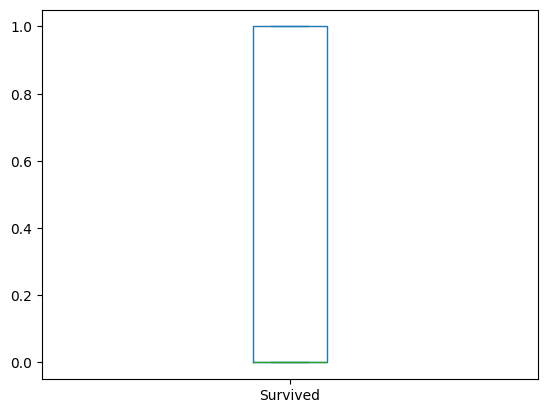

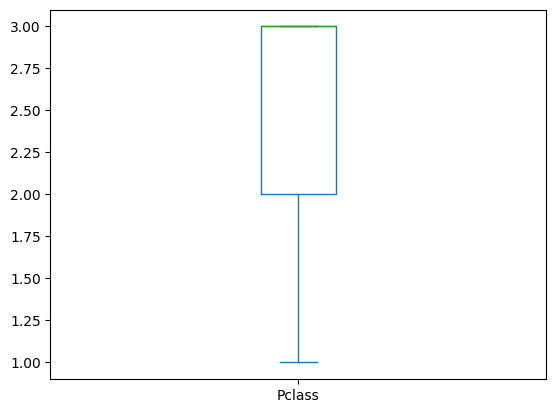

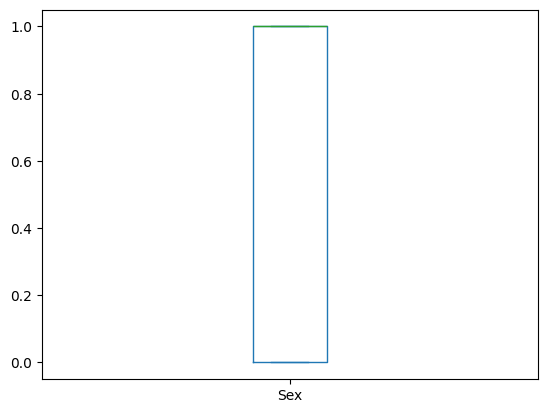

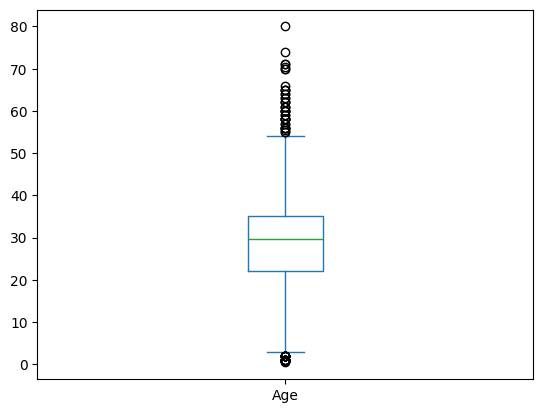

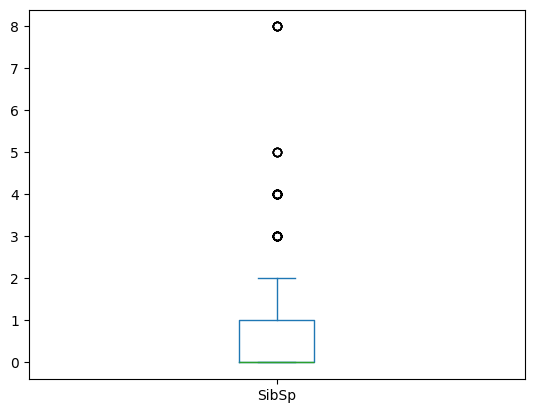

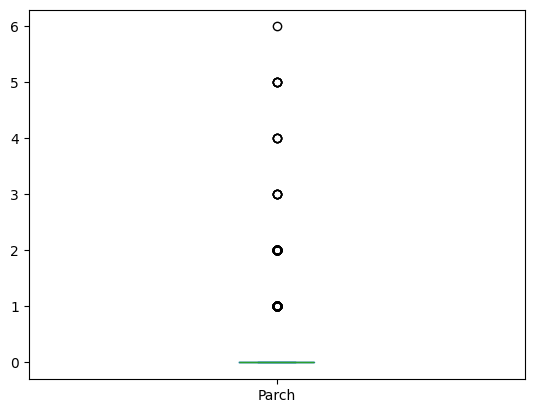

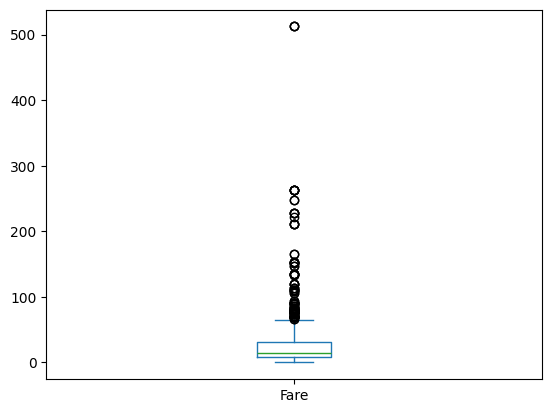

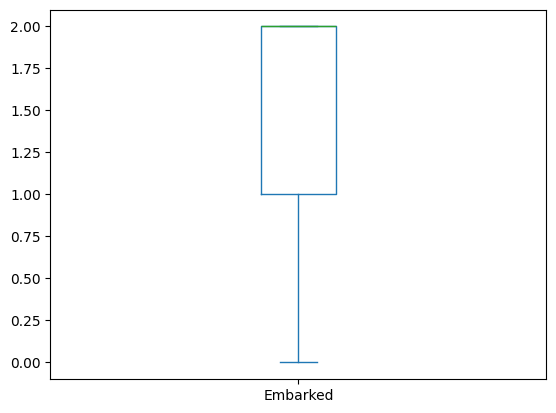

In [428]:
for columns in df.columns:
    df[columns].plot(kind = 'box')
    plt.show()
    #one possible outlier in fare column

In [479]:
#Split the data into features and label
features = df
label = features.pop('Survived')
#Split the data into train test and validation
seed = 42
x_train,x_split,y_train,y_split = model_selection.train_test_split(features,label,test_size=0.2,random_state=seed)
x_val,x_test,y_val,y_test = model_selection.train_test_split(x_split,y_split,test_size=0.3,random_state=seed)


In [653]:
#Model development
model = keras.Sequential()
#Input layer
model.add(keras.Input(shape=(x_train.shape[1],)))
#Normalization layer
normalize = layers.Normalization()
normalize.adapt(x_train.values)
model.add(normalize)
#Hidden layer
regular = regularizers.L2(0.01)
n_layer = 8
for i in range(n_layer):
    if i == 4 : 
        model.add(layers.Dropout(rate = 0.2))
    model.add(layers.Dense(64, activation="relu",kernel_regularizer=regular))
#Output layer
model.add(layers.Dropout(rate=0.8))
model.add(layers.Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_40                │ (None, 7)              │            15 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_267 (Dense)               │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_268 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_269 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_270 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_271 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_272 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_273 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_274 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_275 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,712 (116.06 KB)

 Trainable params: 29,697 (116.00 KB)

 Non-trainable params: 15 (60.00 B)

In [654]:
#compile the model
loss = losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss= loss, metrics=['accuracy','f1_score'])

In [655]:
#save encoder
encoder_path = os.path.join("misc","encoder.pkl")
with open(encoder_path, "wb") as f:
    pickle.dump(encoder, f)

In [ ]:
#Train the model and log it into mlflow
cs = callbacks.EarlyStopping(patience=30,verbose=1)
with mlflow.start_run() as run:
    ml_call = mlflow.keras.MlflowCallback(run)
    history = model.fit(x=x_train,y=y_train,validation_data=(x_val,y_val),epochs=500,batch_size=128, callbacks=[cs,ml_call])
    mlflow.keras.log_model(model, "model")
    mlflow.log_artifact(encoder_path, artifact_path="encoders")

Epoch 1/800
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5125 - f1_score: 0.5523 - loss: 5.2118 - val_accuracy: 0.6290 - val_f1_score: 0.5412 - val_loss: 4.9273
Epoch 2/800
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6264 - f1_score: 0.5512 - loss: 4.8473 - val_accuracy: 0.6290 - val_f1_score: 0.5412 - val_loss: 4.5809
Epoch 3/800
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6265 - f1_score: 0.5397 - loss: 4.5049 - val_accuracy: 0.6290 - val_f1_score: 0.5412 - val_loss: 4.2555
Epoch 4/800
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6176 - f1_score: 0.5541 - loss: 4.1853 - val_accuracy: 0.6290 - val_f1_score: 0.5412 - val_loss: 3.9517
Epoch 5/800
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6155 - f1_score: 0.5530 - loss: 3.8909 - val_accuracy: 0.6290 - val_f1_score: 0.5412 - val_loss: 3.6697
Epoch 6/800
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6098 - f1_score: 0.5612 - loss: 3.6225 - val_accuracy: 0.6290 - val_f1_score: 0.5412 - val_loss:

2025/02/25 13:03:30 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/02/25 13:03:38 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/02/25 13:03:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


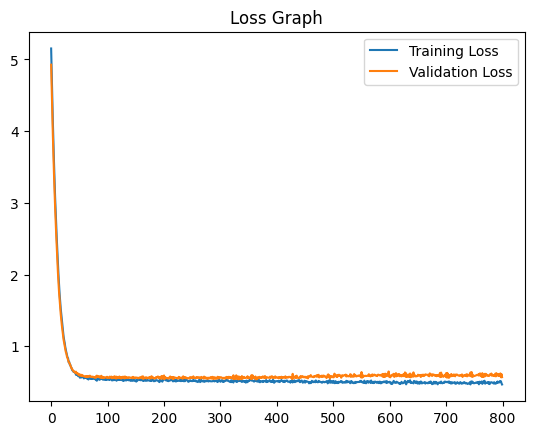

In [657]:
# Plot the graph of loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss Graph")
plt.legend(["Training Loss","Validation Loss"])
plt.show()

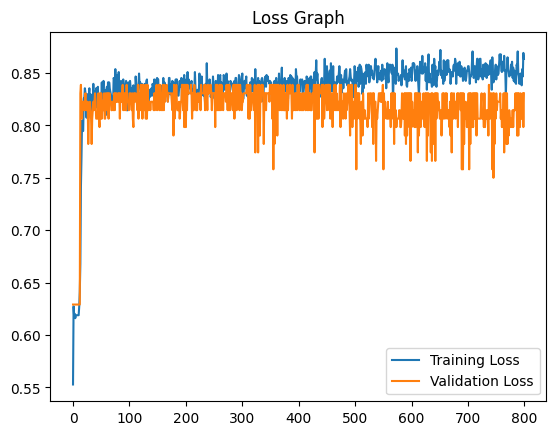

In [658]:
# Plot the graph of loss and accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Loss Graph")
plt.legend(["Training Loss","Validation Loss"])
plt.show()

In [659]:
from sklearn import metrics as skm
print(model.evaluate(x_test,y_test))
y_pred = model.predict(x_test)
y_pred = [1 if x >0.5 else 0 for x in y_pred]
print(y_pred)
print(skm.classification_report(y_test,y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7809 - f1_score: 0.5909 - loss: 0.5483
[0.5263553857803345, 0.7962962985038757, 0.5974025726318359]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1]
              precision    recall  f1-score   support

           0       0.81      0.84      0.83        31
           1       0.77      0.74      0.76        23

    accuracy                           0.80        54
   macro avg       0.79      0.79      0.79        54
weighted avg       0.80      0.80      0.80        54

